# Identifying Top Causes of Stroke: Modifiable vs. Non-modifiable Risk Factors

By: Jenny Huang

# Project Motivation

Stroke is a heterogeneous syndrome, meaning that it is often difficult to pinpoint its specific causes. It is also the leading cause of disability in the United States, and recent studies claim that up to 50% of strokes are preventable [2]. The risk factors of stroke can be separated into two broad categories: modifiable and nonmodifiable [1]. For example, age, sex, race, and genetics are nonmodifiable risk factors, while smoking, diet, and hypertension are commonly reported modifiable risk factors [1].

I am interested in quantifying the importance of modifiable risk factors relative to nonmodifiable risk factors of stroke. If healthcare providers were better able to understand the importance of modifiable risk factors in relation to nonmodifiable ones, they may be able to provide individuals in at-risk populations with compelling information about the importance of adopting lifestyle change. After all, a patient’s belief in the modifiability of their disease risk may greatly influence their willingness to adapt to healthier lifestyle habits as well as to seek treatment for medical conditions like hypertension and diabetes [1].

[1] https://www.ahajournals.org/doi/full/10.1161/CIRCRESAHA.116.308398

[2] https://my.clevelandclinic.org/health/articles/13398-know-your-risk-factors-for-stroke

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns #for plotting
from sklearn.ensemble import RandomForestClassifier #for the model
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz #plot tree
from sklearn.metrics import roc_curve, auc #for model evaluation
from sklearn.metrics import classification_report #for model evaluation
from sklearn.metrics import confusion_matrix #for model evaluation
from sklearn.model_selection import train_test_split #for data splitting
np.random.seed(1) #ensure reproducibility

pd.options.mode.chained_assignment = None  #hide any pandas warnings

In [3]:
pip install dame-flame

Note: you may need to restart the kernel to use updated packages.


# Data Cleaning

In [2]:
import pandas as pd
import numpy as np
import dame_flame
import random
import matplotlib.pyplot as plt

The dataset at hand is an observational dataset containing 11 clinical features for predicting stroke, including age group, hypertension, heart diseases, living conditions, group of bmi, group of glucose level, and smoking status. The dataset is from Kaggle’s Healthcare Dataset, donated by UCI.

In [3]:
sk = pd.read_csv("/Users/JennyH/Documents/sta671/stroke.csv")

In [4]:
sk.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [5]:
# Drop the ID column
sk.drop(columns=['id'],inplace=True) 

In [6]:
# There are 201 null values for bmi. We will drop these values in the cell below.
sk.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [7]:
# Need to transform ever_married to {0,1}
d = {"No": 0, "Yes": 1, "U": np.nan}
sk['ever_married'] = sk['ever_married'].map(d)

# Transforming Gender to {0,1}
d = {"Female":1, "Male": 0}
sk['gender'] = sk['gender'].map(d)


d = {"Urban":1, "Rural": 0}
sk['Residence_type'] = sk['Residence_type'].map(d)

# I bin all continuous variables using medically sound bins.
# Bin age: https://cmdlinetips.com/2019/12/how-to-discretize-bin-a-variable-in-python/
sk['obese']=pd.cut(x = sk['bmi'],
                        bins = [0,30,100], 
                        labels = [0, 1])
sk['high_blood_sugar']=pd.cut(x = sk['avg_glucose_level'],
                        bins = [0,130,300], 
                        labels = [0, 1])
sk['age_bin']=pd.cut(x = sk['age'],
                        bins = [0,25,44,60,82], 
                        labels = [0, 1, 2, 3])

# I use one hot encoding for features with more than one category (ie smoking_status, work_type, age_bin)
prep_data = sk[['smoking_status','work_type', 'age_bin']]
# prep_data
prep_data=pd.get_dummies(prep_data)
prep_data
sk.drop(columns=['smoking_status','work_type'],inplace=True)


# Drop NA values.
sk = sk.dropna()
sk = sk.astype(int) 

In [8]:
# separate y from x.
y=sk['stroke']
sk_with_outcome = sk.copy()
sk.drop(columns=['stroke'],inplace=True)
x=sk.merge(prep_data,left_index=True, right_index=True,how='left')

In [9]:
# remerge the x and the y to create the new dataframe
df = x.merge(y,left_index=True, right_index=True,how='left')

In [10]:
# We will select all of the categorical variables here.

df_trunc = df.loc[:, df.columns.intersection(['age_bin_0', 'age_bin_1', 'age_bin_2', 'age_bin_3', 
                                              'work_type_Govt_job', 'work_type_Never_worked', 'work_type_Private', 'work_type_Self-employed	','work_type_children',
                                              'gender', 'hypertension',
                                    'heart_disease', 'ever_married', 'Residence_type', 
                                              'smoking_status_never smoked', 'smoking_status_formerly smoked','smoking_status_smokes', 'smoking_status_Unknown', 
                                              'high_blood_sugar', 'obese','stroke'])]

## Exploratory Data Analysis

In [11]:
df.describe()

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,obese,high_blood_sugar,...,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,age_bin_0,age_bin_1,age_bin_2,age_bin_3,stroke
count,4908.000000,4908.000000,4908.000000,4908.000000,4908.000000,4908.000000,4908.000000,4908.000000,4908.000000,4908.000000,...,4908.000000,4908.000000,4908.000000,4908.000000,4908.000000,4908.000000,4908.000000,4908.000000,4908.000000,4908.000000
mean,0.590261,42.857579,0.091891,0.049511,0.652812,0.507335,104.808272,28.449878,0.385697,0.173798,...,0.128362,0.004482,0.572535,0.157905,0.136716,0.257539,0.244499,0.250000,0.247963,0.042584
std,0.491836,22.577004,0.288901,0.216954,0.476125,0.499997,44.418565,7.844093,0.486809,0.378974,...,0.334526,0.066808,0.494761,0.364689,0.343582,0.437323,0.429833,0.433057,0.431874,0.201937
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,55.000000,10.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,77.000000,23.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,44.000000,0.000000,0.000000,1.000000,1.000000,91.000000,28.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,60.000000,0.000000,0.000000,1.000000,1.000000,113.000000,33.000000,1.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.250000,0.000000,0.000000
max,1.000000,82.000000,1.000000,1.000000,1.000000,1.000000,271.000000,97.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [12]:
# The vast majority of units in the dataset do not have stroke. Hence, we see an imbalance in the data.
df_trunc['stroke'].value_counts()

0    4699
1     209
Name: stroke, dtype: int64

In [13]:
df_trunc.apply(pd.Series.value_counts)

,gender,hypertension,heart_disease,ever_married,Residence_type,obese,high_blood_sugar,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_children,age_bin_0,age_bin_1,age_bin_2,age_bin_3,stroke
0,2011,4457,4665,1704,2418,3015,4055,3425,4072,3056,4171,4278,4886,2098,4237,3644,3708,3681,3691,4699
1,2897,451,243,3204,2490,1893,853,1483,836,1852,737,630,22,2810,671,1264,1200,1227,1217,209


For treatment variables such as hypertension, heart_disease, and certain work_types, we see imbalance between the treatment and control groups. Hence, I will choose to run the FLAME algorithm with repeats=True.

In [15]:
# creating count tables to explore each categorical feature.
heart = df_trunc.groupby(['heart_disease', 'stroke']).agg({'stroke': 'count'}).rename(columns = {'stroke': 'count'}).reset_index()
heart.iloc[[0,1], 0] = 'No heart diseases'
heart.iloc[[2,3], 0] = 'Heart diseases'
heart.iloc[[0,2], 1] = "Didn't have a stroke"
heart.iloc[[1,3], 1] = "Had a stroke"

g = df_trunc.groupby(['gender', 'stroke']).agg({'stroke': 'count'}).rename(columns = {'stroke': 'count'}).reset_index()
g.iloc[[0,1], 0] = 'Male'
g.iloc[[2,3], 0] = 'Female'
g.iloc[[0,2], 1] = "Didn't have a stroke"
g.iloc[[1,3], 1] = "Had a stroke"


marry = df_trunc.groupby(['ever_married', 'stroke']).agg({'stroke': 'count'}).rename(columns = {'stroke': 'count'}).reset_index()
marry.iloc[[0,1], 0] = 'Not ever married'
marry.iloc[[2,3], 0] = 'married (or previously)'
marry.iloc[[0,2], 1] = "Didn't have a stroke"
marry.iloc[[1,3], 1] = "Had a stroke"

hbs = df_trunc.groupby(['high_blood_sugar', 'stroke']).agg({'stroke': 'count'}).rename(columns = {'stroke': 'count'}).reset_index()
hbs.iloc[[0,1], 0] = 'No High Blood Sugar'
hbs.iloc[[2,3], 0] = 'High Blood Sugar'
hbs.iloc[[0,2], 1] = "Didn't have a stroke"
hbs.iloc[[1,3], 1] = "Had a stroke"

htn = df_trunc.groupby(['hypertension', 'stroke']).agg({'stroke': 'count'}).rename(columns = {'stroke': 'count'}).reset_index()
htn.iloc[[0,1], 0] = 'No Hypertension'
htn.iloc[[2,3], 0] = 'Hypertension'
htn.iloc[[0,2], 1] = "Didn't have a stroke"
htn.iloc[[1,3], 1] = "Had a stroke"


In [17]:
fig = plt.figure(figsize = (12, 60))
fig.patch.set_facecolor('#fafafa')

<Figure size 864x4320 with 0 Axes>

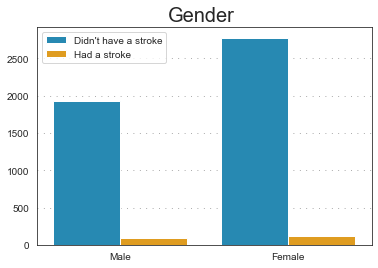

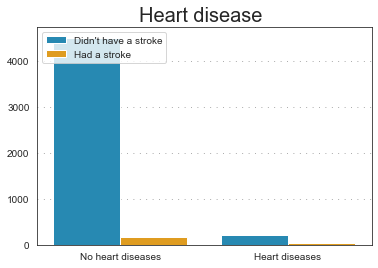

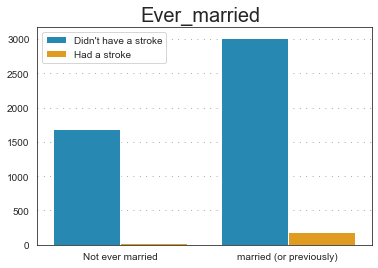

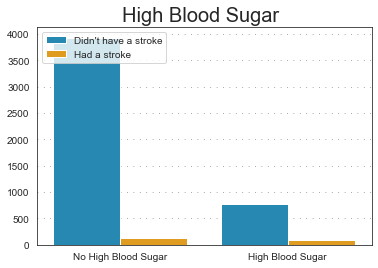

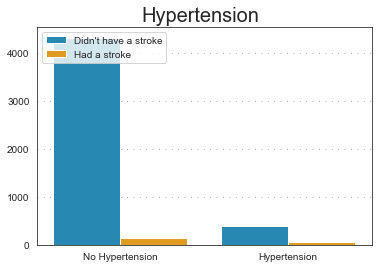

In [20]:
# bar plots of select categorical variables.
sns.set_style('white')
plt.title('Gender', size = 20, x = 0.49, y = 1.00)
plt.grid(color = 'gray', linestyle = ':', axis = 'y', zorder = 0,  dashes = (1,7))
c = sns.barplot(data = heart, x = g['gender'], y = g['count'], hue = g['stroke'], palette = ['#1092c9','orange'])
plt.ylabel('')
plt.xlabel('')
plt.legend(loc = 'upper left')
plt.show()

sns.set_style('white')
plt.title('Heart disease', size = 20, x = 0.49, y = 1.00)
plt.grid(color = 'gray', linestyle = ':', axis = 'y', zorder = 0,  dashes = (1,7))
c = sns.barplot(data = heart, x = heart['heart_disease'], y = heart['count'], hue = heart['stroke'], palette = ['#1092c9','orange'])
plt.ylabel('')
plt.xlabel('')
plt.legend(loc = 'upper left')
plt.show()

sns.set_style('white')
plt.title('Ever_married', size = 20, x = 0.49, y = 1.00)
plt.grid(color = 'gray', linestyle = ':', axis = 'y', zorder = 0,  dashes = (1,7))
c = sns.barplot(data = heart, x = marry['ever_married'], y = marry['count'], hue = marry['stroke'], palette = ['#1092c9','orange'])
plt.ylabel('')
plt.xlabel('')
plt.legend(loc = 'upper left')
plt.show()

sns.set_style('white')
plt.title('High Blood Sugar', size = 20, x = 0.49, y = 1.00)
plt.grid(color = 'gray', linestyle = ':', axis = 'y', zorder = 0,  dashes = (1,7))
c = sns.barplot(data = heart, x = hbs['high_blood_sugar'], y = hbs['count'], hue = hbs['stroke'], palette = ['#1092c9','orange'])
plt.ylabel('')
plt.xlabel('')
plt.legend(loc = 'upper left')
plt.show()

sns.set_style('white')
plt.title('Hypertension', size = 20, x = 0.49, y = 1.00)
plt.grid(color = 'gray', linestyle = ':', axis = 'y', zorder = 0,  dashes = (1,7))
c = sns.barplot(data = heart, x = htn['hypertension'], y = htn['count'], hue = htn['stroke'], palette = ['#1092c9','orange'])
plt.ylabel('')
plt.xlabel('')
plt.legend(loc = 'upper left')
plt.show()



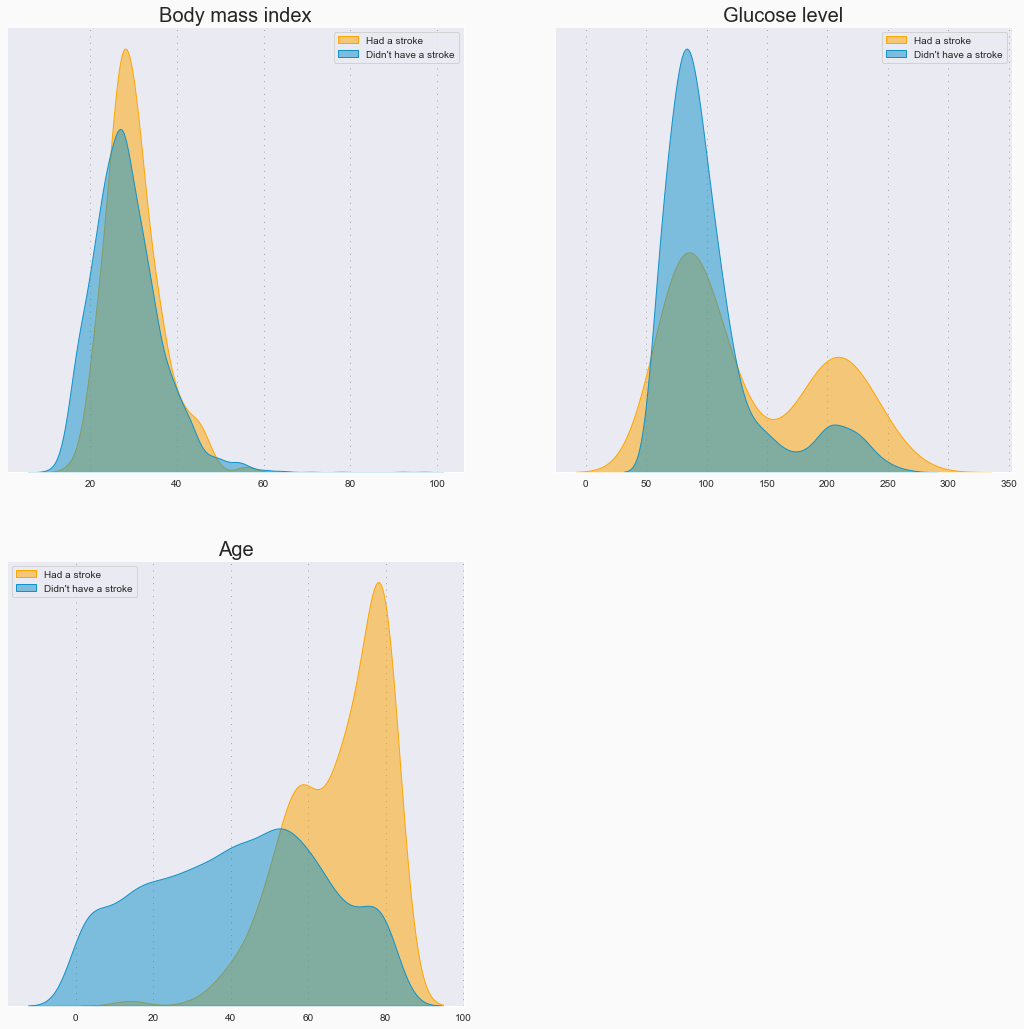

In [158]:
# Continuous Variables By Stroke

fig = plt.figure(figsize = (18, 18))
fig.patch.set_facecolor('#fafafa')

plt.subplot(221)
plt.title('Body mass index', size = 20)
sns.kdeplot(sk_with_outcome.query('stroke == 1')['bmi'], color = 'orange', shade = True, label = 'Had a stroke', alpha = 0.5)
sns.kdeplot(sk_with_outcome.query('stroke == 0')['bmi'], color = '#1092c9', shade = True, label = "Didn't have a stroke", alpha = 0.5)
plt.grid(color = 'gray', linestyle = ':', axis = 'x', zorder = 0,  dashes = (1,7))
plt.ylabel('')
plt.xlabel('')
plt.yticks([])
plt.legend(loc = 'upper right')

plt.subplot(222)
plt.title('Glucose level', size = 20)
sns.kdeplot(sk_with_outcome.query('stroke == 1')['avg_glucose_level'], color = 'orange', shade = True, label = 'Had a stroke', alpha = 0.5)
sns.kdeplot(sk_with_outcome.query('stroke == 0')['avg_glucose_level'], color = '#1092c9', shade = True, label = "Didn't have a stroke", alpha = 0.5)
plt.grid(color = 'gray', linestyle = ':', axis = 'x', zorder = 0,  dashes = (1,7))
plt.ylabel('')
plt.xlabel('')
plt.yticks([])
plt.legend(loc = 'upper right')

plt.subplot(223)
sns.set_style("dark")
plt.title('Age', size = 20)
sns.kdeplot(sk_with_outcome.query('stroke == 1')['age'], color = 'orange', shade = True, label = 'Had a stroke', alpha = 0.5)
sns.kdeplot(sk_with_outcome.query('stroke == 0')['age'], color = '#1092c9', shade = True, label = "Didn't have a stroke", alpha = 0.5)
plt.grid(color = 'gray', linestyle = ':', axis = 'x', zorder = 0,  dashes = (1,7))
plt.ylabel('')
plt.xlabel('')
plt.yticks([])
plt.legend(loc = 'upper left')

### Conditions for Matching

In order to use matching, a series of assumptions on the data must be satisfied. First, we assume that treatments applied to one unit should not affect the outcome of another unit. Assuming that the subjects in the dataset were drawn independently from the general population, then the treatment of one subject in the dataset should not affect the outcome of another subject. Next, the unconfoundedness assumption must be satisfied. Here, we assume that no confounding covariates that are important in determining stroke have been left out from the dataset. This is a reasonable assumption, as our stroke dataset includes the major clinical factors used in stroke predictions in past studies (hypertension, age, and heart disease). Finally, the dataset must not contain overlap in the treatment and control groups. This is not a problem, as the FLAME algorithm would not make matches in that case, and no treatment effect estimate would be possible.

# THE FLAME ALGORITHM

In this example, I will use the "heart_disease" feature as the treatment variable for outcome of stroke.

In [24]:
df_trunc

,gender,hypertension,heart_disease,ever_married,Residence_type,obese,high_blood_sugar,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_children,age_bin_0,age_bin_1,age_bin_2,age_bin_3,stroke
0,0,0,1,1,1,1,1,0,1,0,0,0,0,1,0,0,0,0,1,1
2,0,0,1,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,1
3,1,0,0,1,1,1,1,0,0,0,1,0,0,1,0,0,0,1,0,1
4,1,1,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,1
5,0,0,0,1,1,0,1,0,1,0,0,0,0,1,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5104,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0
5106,1,0,0,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0
5107,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0
5108,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0


In [25]:
model_flame_HD = dame_flame.matching.FLAME(repeats=True, verbose=3, adaptive_weights='ridge', alpha=0.1, want_pe=True, early_stop_iterations=30)

In [26]:
model_flame_HD.fit(holdout_data=df_trunc, treatment_column_name='heart_disease', outcome_column_name='stroke')
result_flame_HD = model_flame_HD.predict(df_trunc)

Iteration number:  1
	Number of matched groups formed in total:  149
	Unmatched treated units:  42 out of a total of  243 treated units
	Unmatched control units:  3707 out of a total of  4665 control units
	Predictive error of covariates chosen this iteration:  0
	Number of matches made in this iteration:  1159
	Number of matches made so far:  1159
	In this iteration, the covariates dropped are:  set()
Iteration number:  2
	Number of matched groups formed in total:  240
	Unmatched treated units:  21 out of a total of  243 treated units
	Unmatched control units:  3199 out of a total of  4665 control units
	Predictive error of covariates chosen this iteration:  0.15668503347540913
	Number of matches made in this iteration:  529
	Number of matches made so far:  1688
	In this iteration, the covariates dropped are:  Residence_type
Iteration number:  3
	Number of matched groups formed in total:  303
	Unmatched treated units:  3 out of a total of  243 treated units
	Unmatched control units:  

In [27]:
# FLAME is highly interpretable. For each unit, we can see the covariates it was matched on.
model_flame_HD.df_units_and_covars_matched[:10]

,gender,hypertension,ever_married,Residence_type,obese,high_blood_sugar,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_children,age_bin_0,age_bin_1,age_bin_2,age_bin_3
0,0,0,1,1,1,1,0,1,0,0,0,0,1,0,0,0,0,1
2,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1
3,1,0,1,1,1,1,0,0,0,1,0,0,1,0,0,0,1,0
4,1,*,*,*,0,1,0,0,1,0,0,0,0,0,0,0,0,1
5,0,0,1,1,0,1,0,1,0,0,0,0,1,0,0,0,0,1
6,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1
7,1,0,*,*,0,0,0,0,1,0,0,0,1,0,0,0,0,1
9,*,*,*,*,0,0,1,0,0,0,0,0,1,0,0,0,0,1
10,1,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1
11,1,0,1,*,1,0,0,0,0,1,1,0,0,0,0,0,0,1


Taking a preliminary look at the covariates FLAME matched the units on, covariate choices seem in line with medically relevant factors in stroke prediction (covariates such as age, hypertension, work type, and smoking status)! FLAME seemed to drop variables like Residence_type and ever_married most often, and dropped covariates are indicated by a *)

## Hyperparameter Tuning: Deciding on best choice for adaptive_weight

### Method 1: Decision Tree Classifier

In [19]:
df_trunc.head()

,gender,hypertension,heart_disease,ever_married,Residence_type,obese,high_blood_sugar,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_children,age_bin_0,age_bin_1,age_bin_2,age_bin_3,stroke
0,0,0,1,1,1,1,1,0,1,0,0,0,0,1,0,0,0,0,1,1
2,0,0,1,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,1
3,1,0,0,1,1,1,1,0,0,0,1,0,0,1,0,0,0,1,0,1
4,1,1,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,1
5,0,0,0,1,1,0,1,0,1,0,0,0,0,1,0,0,0,0,1,1


In [20]:
X_train, X_test, y_train, y_test = train_test_split(df_trunc.drop('stroke', 1), df_trunc['stroke'], test_size = .2, random_state=9) #split the data


In [21]:
model = DecisionTreeClassifier(max_depth=5)
model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5)

In [22]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
k_f = KFold(n_splits=5)
k_f

accuracy_mean = []
accuracy_sd = []
accuracy_report = []

# use plot to determine the best model

for i in ["gini", "entropy"]:
  # splitting criteria: gini or entropy
  for k in range(1, 11):
    # max_depth of tree
    cv = cross_val_score(DecisionTreeClassifier(criterion = i, max_depth=k), X_train, y_train, cv=5, scoring='accuracy')
    curr_mean = cv.mean()
    curr_sd = cv.std()

    accuracy_mean.append(curr_mean)
    accuracy_sd.append(curr_sd)

    accuracy_report.append("%0.4f (+/- %0.2f)" % (cv.mean(), cv.std() * 2))

print(accuracy_report) # a list of reported accuracies (95% CIs)

['0.9592 (+/- 0.00)', '0.9592 (+/- 0.00)', '0.9592 (+/- 0.00)', '0.9580 (+/- 0.01)', '0.9577 (+/- 0.00)', '0.9575 (+/- 0.00)', '0.9570 (+/- 0.00)', '0.9526 (+/- 0.01)', '0.9498 (+/- 0.01)', '0.9457 (+/- 0.01)', '0.9592 (+/- 0.00)', '0.9592 (+/- 0.00)', '0.9592 (+/- 0.00)', '0.9592 (+/- 0.00)', '0.9570 (+/- 0.00)', '0.9575 (+/- 0.00)', '0.9564 (+/- 0.00)', '0.9536 (+/- 0.01)', '0.9508 (+/- 0.01)', '0.9473 (+/- 0.01)']


In [23]:
# make list of gini and entropy accuracies for graph below.
gini_accuracy = accuracy_mean[0:10]
entropy_accuracy = accuracy_mean[10:20]

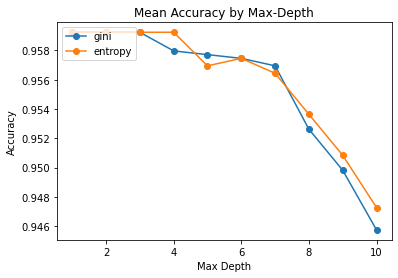

In [24]:
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(1, 10, 10)

fig = plt.figure()
ax1 = fig.add_subplot(111)

plt.plot(x, gini_accuracy, '-o', label = "gini")
plt.plot(x, entropy_accuracy, '-o', label = "entropy")

plt.legend(loc='upper left');
plt.title("Mean Accuracy by Max-Depth")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy")
plt.show()

From the plot above, we see that entropy with a max depth of 4 gives the highest validation accuracy (0.9592 (+/- 0.00) for the DecisionTreeClassifier.

### Method 2: Ridge Regression

In [25]:
from sklearn.linear_model import RidgeClassifier

In [26]:
accuracy_mean = []
accuracy_sd = []
accuracy_report = []

# use plot to determine the best model

for reg in [0.001, 0.01, 0.1, 1, 10, 100]:
    # regularization penalty
    cv = cross_val_score(RidgeClassifier(alpha=reg), X_train, y_train, cv=5, scoring='accuracy')
    curr_mean = cv.mean()
    curr_sd = cv.std()

    accuracy_mean.append(curr_mean)
    accuracy_sd.append(curr_sd)

    accuracy_report.append("%0.3f (+/- %0.2f)" % (cv.mean(), cv.std() * 2))

print(accuracy_report) # a list of reported accuracies (95% CIs)

['0.959 (+/- 0.00)', '0.959 (+/- 0.00)', '0.959 (+/- 0.00)', '0.959 (+/- 0.00)', '0.959 (+/- 0.00)', '0.959 (+/- 0.00)']


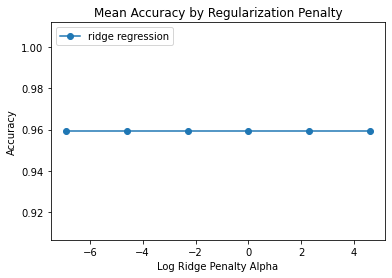

In [27]:
import matplotlib.pyplot as plt
import numpy as np

x = np.log([0.001, 0.01, 0.1, 1, 10, 100])

fig = plt.figure()
ax1 = fig.add_subplot(111)

plt.plot(x, accuracy_mean, '-o', label = "ridge regression")

plt.legend(loc='upper left');
plt.title("Mean Accuracy by Regularization Penalty")
plt.xlabel("Log Ridge Penalty Alpha")
plt.ylabel("Accuracy")
plt.show()

Ridge regression performs similarly to the best DecisionTree model, so we will use ridge regression as the adaptive weight within the FLAME algorithm. The regularization penalty does not seem to influence the validation accuracy. Hence, we will set alpha to the default value 0.1.

# Results: Average Treatment Effect

To rank the causes of stroke, we will examine the effects of each of the following covariates on stroke. To do this, we run the FLAME model multiple times in a loop, each time using a different covariate as the designated 'treatment' variable.

In [28]:
feature_names = df_trunc.columns 
feature_names = feature_names[:-1]

In [29]:
# Loop through each of these "treatment" variables to determine the top causes of occurence of stroke.
feature_names

Index(['gender', 'hypertension', 'heart_disease', 'ever_married',
       'Residence_type', 'obese', 'high_blood_sugar', 'smoking_status_Unknown',
       'smoking_status_formerly smoked', 'smoking_status_never smoked',
       'smoking_status_smokes', 'work_type_Govt_job', 'work_type_Never_worked',
       'work_type_Private', 'work_type_children', 'age_bin_0', 'age_bin_1',
       'age_bin_2', 'age_bin_3'],
      dtype='object')

In [30]:
model_flame = dame_flame.matching.FLAME(repeats=True, verbose=3, adaptive_weights='ridge', alpha=0.1, want_pe=True, early_stop_iterations=30)

In [ ]:
ATE_LIST = []

for i in range(len(feature_names)):
#     print(feature_names[i])
    model_flame.fit(holdout_data=df_trunc, treatment_column_name=feature_names[i], outcome_column_name='stroke')
    model_flame.predict(df_trunc)
    ate = dame_flame.utils.post_processing.ATE(model_flame)
    ATE_LIST.append(ate)       

In [32]:
print(feature_names)
len(ATE_LIST)

Index(['gender', 'hypertension', 'heart_disease', 'ever_married',
       'Residence_type', 'obese', 'high_blood_sugar', 'smoking_status_Unknown',
       'smoking_status_formerly smoked', 'smoking_status_never smoked',
       'smoking_status_smokes', 'work_type_Govt_job', 'work_type_Never_worked',
       'work_type_Private', 'work_type_children', 'age_bin_0', 'age_bin_1',
       'age_bin_2', 'age_bin_3'],
      dtype='object')


19

In [33]:
# Ranking of treatment effects: Larger ATE value means a covariate is more predictive of stroke. 
names_ATE = []
for i in range(len(feature_names)):
    names_ATE.append((feature_names[i], ATE_LIST[i]))
names_ATE

# sort by average treatment effect.
names_ATE.sort(key=lambda names_ATE: names_ATE[1])
names_ATE

[('age_bin_1', -0.036011379192618896),
 ('age_bin_0', -0.03216242105190894),
 ('work_type_Never_worked', -0.01823294327079747),
 ('work_type_children', -0.017973113120769244),
 ('age_bin_2', -0.010739964083528394),
 ('smoking_status_Unknown', -0.005865250376357788),
 ('work_type_Govt_job', -0.005352798802071218),
 ('ever_married', -0.00340693809979216),
 ('smoking_status_never smoked', -0.001984726108970916),
 ('work_type_Private', 0.001591695099257064),
 ('Residence_type', 0.0021149714740288975),
 ('obese', 0.00315276749054838),
 ('smoking_status_smokes', 0.005327925155501201),
 ('smoking_status_formerly smoked', 0.005565067130122559),
 ('heart_disease', 0.006077762579679605),
 ('gender', 0.0064754030367190655),
 ('hypertension', 0.01942635278790051),
 ('high_blood_sugar', 0.025806685758345705),
 ('age_bin_3', 0.07799270652844659)]

In [34]:
treatment = ('gender',
 'hypertension',
 'heart_disease',
 'ever_married',
 'Residence_type',
 'obese',
 'high_blood_sugar',
 'smoking_status_Unknown',
 'smoking_status_formerly smoked',
 'smoking_status_never smoked',
 'smoking_status_smokes',
 'work_type_Govt_job',
 'work_type_Never_worked',
 'work_type_Private',
 'work_type_children',
 'age_bin_0',
 'age_bin_1',
 'age_bin_2',
 'age_bin_3')

In [37]:
import plotly.graph_objects as go # https://www.geeksforgeeks.org/diverging-bar-chart-using-python/

# Creating a Figure
Diverging = go.Figure()

Diverging.add_trace(go.Bar(x=ATE_LIST,
                               y=treatment,
                               orientation='h',
                               name=treatment[0],
                               customdata=ATE_LIST,
                               hovertemplate="%{y}: %{customdata}"))

Diverging.update_layout(
    xaxis_title="Average Treatment Effect (in difference of proportions)",
    yaxis_title="Treatment Variable",
    legend_title="Legend Title",
    font=dict(
        family="Courier New, monospace",
        size=12,
        color="Black"
    ),
    title={
        'text': "Identifying Causes of Stroke",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

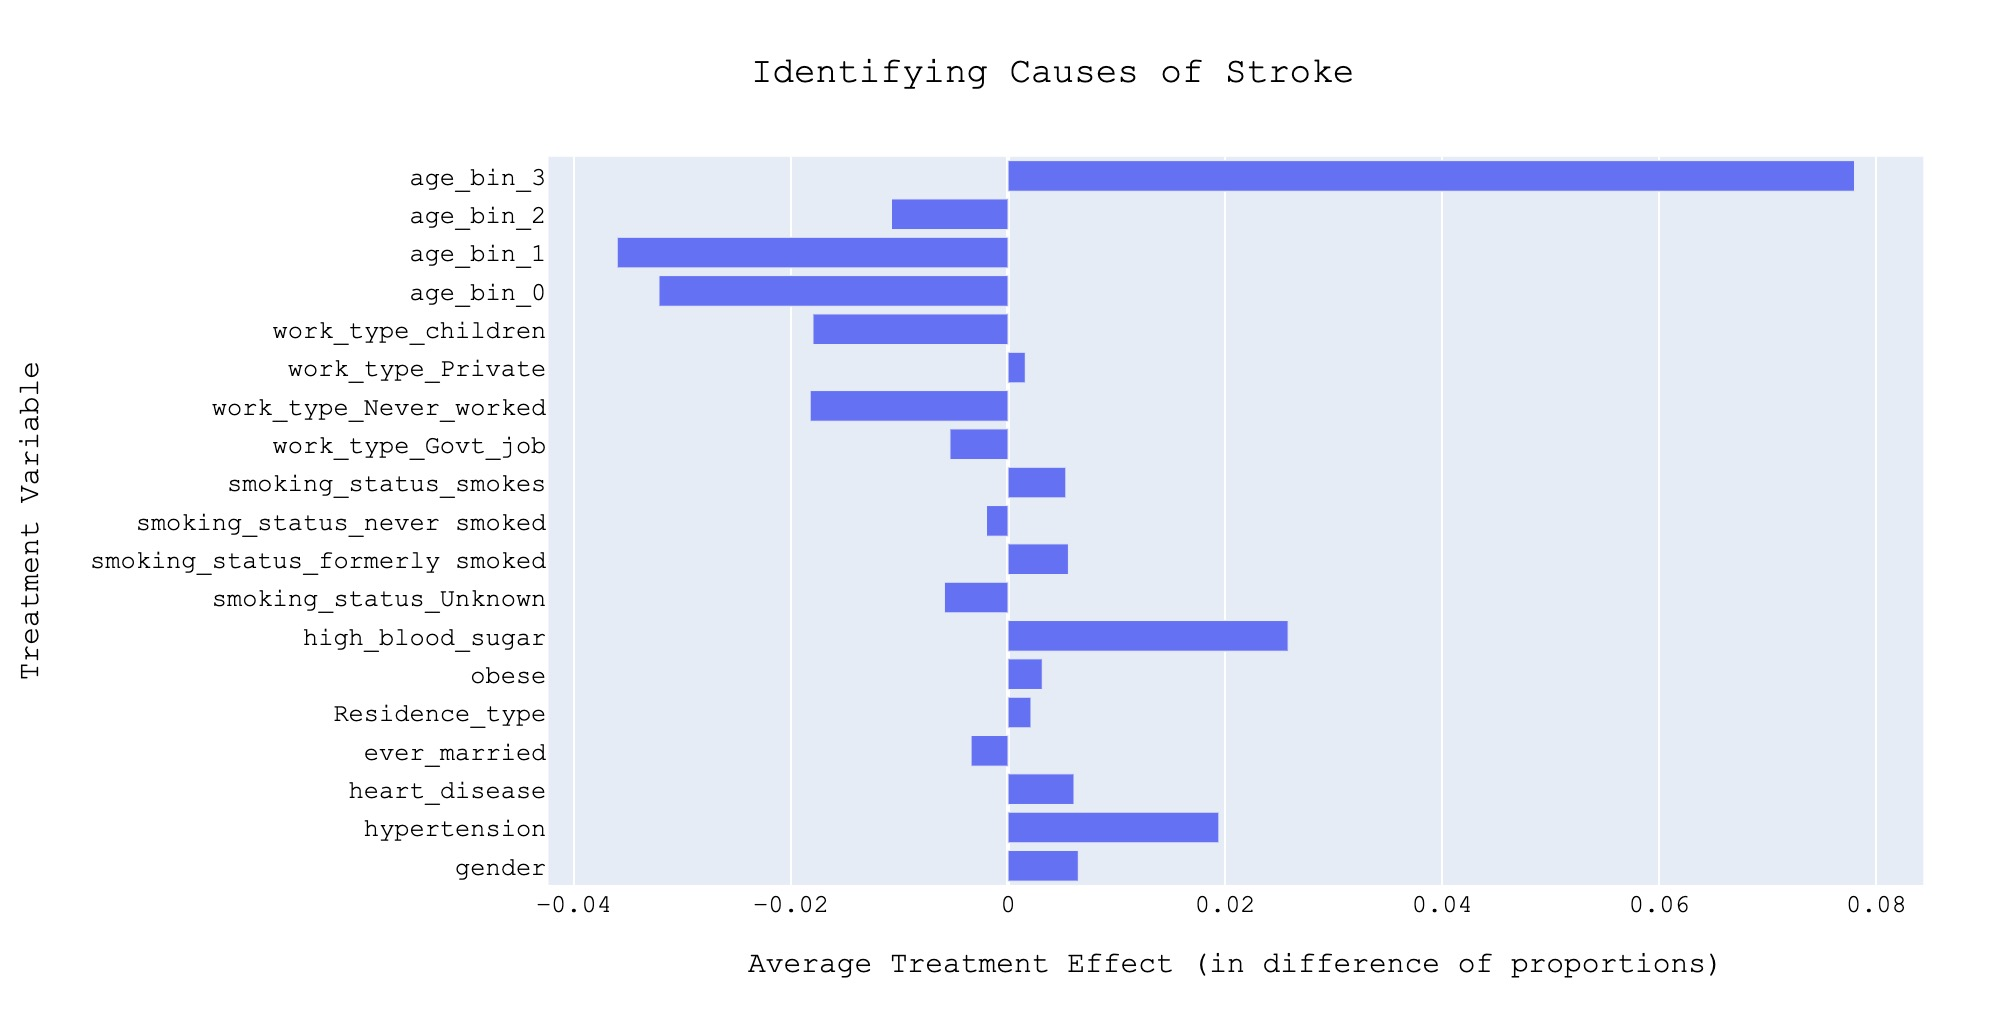

LEGEND:

age_bin_0 - ages 0-25
age_bin_1 - ages 25-44
age_bin_2 - ages 44-60
age_bin_3 - ages 60-82
gender - indicator variable for being Male.
residence_type - indicator variable for living in an urban area. (rural=0)
obese - indicator variable for having a bmi over 30.
high_blood_sugar - indicator variable for having high blood sugar (avg_glucose over 130)
ever_married - indicator variable for being currently or previously married.

Overall, the ATE results lead us to believe that the leading causes of stroke (out of covariates in the dataset) are, in order, old age, high blood sugar, hypertension, heart disease, and having a gender of female. These top covariates are in agreement with general medical literature about the factors influencing stroke [10]. 

Among the top 5 features that have the greatest positive causal effect on stroke, high blood sugar, heart-disease, and hypertension are all modifiable risk factors, as individuals can seek medical treatment and pursue lifestyle changes in order to manage their blook sugar and blood pressure. Hence, a key takeaway is that seeking treatment for medical conditions such as diabetes, hypertension, and heart disease are crucial in the prevention of stroke. Finally, we also see that smoking, another modifiable risk factor, has a slight positive treatment effect on stroke. 

We see that age, a non-modifiable feature, is the top influencer of increasing the risk of stroke. Individuals in age_bin_3 (between ages 60-82) are at much higher risk of stroke than patients in the other age groups. The age group with the lowest risk of stroke is age_bin_1 (between ages 25-44). According to the NIH, over 70% of all strokes occur above the age of 65, and incidence of stroke doubles with each decade after the age of 45 years [11].

Among the treatment variables that decrease risk of stroke are being young in age as well as career type. Individuals who work with children (work_type_children) have a decreased risk of stroke. There have been studies which have shown that having children is associated with a decrease in blood pressure [9]. Individuals who have never worked also have a decreased risk. While it is tempting to think that "never_worked" is being confounded with young age, recall that FLAME takes this confounding into consideration through matching. That is, the estimation of treatment effect is calculated through matching each treatment unit (individual who has never worked) with a control unit (individual who HAS worked) who is near identical in all other features aside from work type.

Since the outcome was a binary (Stroke = {0,1}) variable, the ATE is the expect difference between the proportion of subjects who experienced stroke in the treatment group and the proportion who experienced stroke in the control group (this would also explain why the ATE values are all small in magnitude).

# Heterogeneity in CATE

We will look at the heterogeneity in CATE of the top three most important treatment variables.

In [2]:
# model_flame_HD = dame_flame.matching.FLAME(repeats=True, verbose=3, adaptive_weights='ridge', alpha=0.1, want_pe=True, early_stop_iterations=30)
# model_flame_HD.fit(holdout_data=df_trunc, treatment_column_name='heart_disease', outcome_column_name='stroke')
# res_flame_HD = model_flame_HD.predict(df_trunc)

In [16]:
group_size_treated = []
group_size_overall = []
cate_of_group = []
for group in model_flame_HD.units_per_group:
    
    # find len of just treated units
    df_mmg = df_trunc.loc[group]
    treated = df_mmg.loc[df_mmg["heart_disease"] == 1]
    
    group_size_treated.append(len(treated))
    group_size_overall.append(len(group))
    
    cate_of_group.append(dame_flame.utils.post_processing.CATE(model_flame_HD, group[0]))

Text(0, 0.5, 'Estimated Treatment Effect of Group')

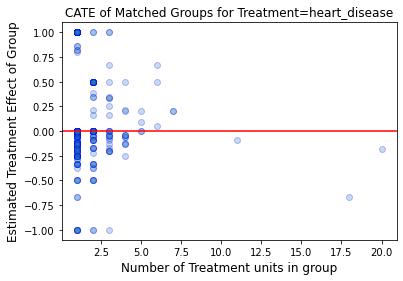

In [17]:
plt.scatter(group_size_treated, cate_of_group, alpha=0.25, edgecolors='b')
plt.axhline(y=0.0, color='r', linestyle='-')
plt.title('CATE of Matched Groups for Treatment=heart_disease')
plt.xlabel('Number of Treatment units in group', fontsize=12)
plt.ylabel('Estimated Treatment Effect of Group', fontsize=12)

In [34]:
# model_flame_elderly = dame_flame.matching.FLAME(repeats=True, verbose=3, adaptive_weights='ridge', alpha=0.1, want_pe=True, early_stop_iterations=30)
# model_flame_elderly.fit(holdout_data=df_trunc, treatment_column_name='age_bin_3', outcome_column_name='stroke')
# # why is this not working after adding age_bin?
# res_flame_elderly = model_flame_elderly.predict(df_trunc)

In [27]:
group_size_treated = []
group_size_overall = []
cate_of_group = []
for group in model_flame_elderly.units_per_group:
    
    # find len of just treated units
    df_mmg = df_trunc.loc[group]
    treated = df_mmg.loc[df_mmg["age_bin_3"] == 1]
    
    group_size_treated.append(len(treated))
    group_size_overall.append(len(group))
    
    cate_of_group.append(dame_flame.utils.post_processing.CATE(model_flame_elderly, group[0]))

Text(0, 0.5, 'Estimated Treatment Effect of Group')

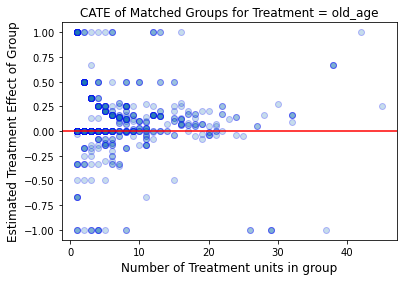

In [29]:
plt.scatter(group_size_treated, cate_of_group, alpha=0.25, edgecolors='b')
plt.axhline(y=0.0, color='r', linestyle='-')
plt.title('CATE of Matched Groups for Treatment=old_age')
plt.xlabel('Number of Treatment units in group', fontsize=12)
plt.ylabel('Estimated Treatment Effect of Group', fontsize=12)

In [33]:
# model_flame_ht = dame_flame.matching.FLAME(repeats=True, verbose=3, adaptive_weights='ridge', alpha=0.1, want_pe=True, early_stop_iterations=30)
# model_flame_ht.fit(holdout_data=df_trunc, treatment_column_name='hypertension', outcome_column_name='stroke')
# # why is this not working after adding age_bin?
# res_flame_ht = model_flame_ht.predict(df_trunc)

In [31]:
group_size_treated = []
group_size_overall = []
cate_of_group = []
for group in model_flame_ht.units_per_group:
    
    # find len of just treated units
    df_mmg = df_trunc.loc[group]
    treated = df_mmg.loc[df_mmg["age_bin_3"] == 1]
    
    group_size_treated.append(len(treated))
    group_size_overall.append(len(group))
    
    cate_of_group.append(dame_flame.utils.post_processing.CATE(model_flame_ht, group[0]))

Text(0, 0.5, 'Estimated Treatment Effect of Group')

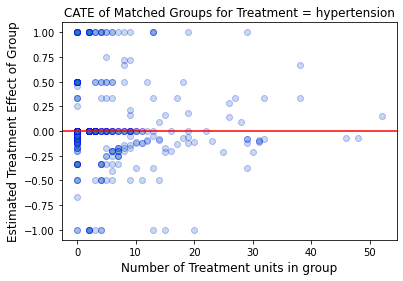

In [32]:
plt.scatter(group_size_treated, cate_of_group, alpha=0.25, edgecolors='b')
plt.axhline(y=0.0, color='r', linestyle='-')
plt.title('CATE of Matched Groups for Treatment=hypertension')
plt.xlabel('Number of Treatment units in group', fontsize=12)
plt.ylabel('Estimated Treatment Effect of Group', fontsize=12)

### Variable Importance Approach

In [42]:
### SVM_Variable_Importance

In [56]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(x.to_numpy(),y.to_numpy(),test_size=0.20,random_state=1)

In [58]:
#Using SVC method of svm class to use Support Vector Machine Algorithm
from sklearn.svm import SVC
svc_lin = SVC(kernel = 'linear', random_state =0)
svc_lin.fit(X_train, Y_train)

#Using SVC method of svm class to use Kernel SVM Algorithm
from sklearn.svm import SVC
svc_rbf = SVC(kernel = 'rbf', random_state = 0)
svc_rbf.fit(X_train, Y_train)

SVC(random_state=0)

In [59]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

print("The Accuracy for the linear svm is: ", accuracy_score(Y_test, svc_lin.predict(X_test)))

print("The Classification Report for the linear svm:")
print( classification_report(Y_test, svc_lin.predict(X_test)) )

print("The Accuracy for the RBF svm is: ", accuracy_score(Y_test, svc_rbf.predict(X_test)))

print("The Classification Report for the radial basis function svm:")
print( classification_report(Y_test, svc_rbf.predict(X_test)) )

The Accuracy for the linear svm is:  0.9228723404255319
The Classification Report for the linear svm:
              precision    recall  f1-score   support

           0       0.89      0.96      0.93       930
           1       0.96      0.88      0.92       950

    accuracy                           0.92      1880
   macro avg       0.93      0.92      0.92      1880
weighted avg       0.93      0.92      0.92      1880

The Accuracy for the RBF svm is:  0.7569148936170212
The Classification Report for the radial basis function svm:
              precision    recall  f1-score   support

           0       0.78      0.71      0.74       930
           1       0.74      0.80      0.77       950

    accuracy                           0.76      1880
   macro avg       0.76      0.76      0.76      1880
weighted avg       0.76      0.76      0.76      1880



Now to estimate causal effects, we will rank variable importance.

In [60]:
# Accuracy
accuracy_linear = accuracy_score(Y_test, svc_lin.predict(X_test))
original_loss = 1-accuracy_linear

# We will use the zero_one loss.
original_loss

0.0771276595744681

In [61]:
# create lists to store the scrambled data.
training_scramble = []
testing_scramble = []

In [62]:
for i in range(len(x.columns)-1):
    X_train_scramble, X_test_scramble = X_train.copy(), X_test.copy()
    
    # scramble the column on train/test data
    col_train = X_train_scramble[:,i]
    col_test = X_test_scramble[:,i]
    
    random.shuffle(col_train)
    random.shuffle(col_test)
    
    X_train_scramble[:,i] = col_train
    X_test_scramble[:,i] = col_test
    
    training_scramble.append(X_train_scramble)
    testing_scramble.append(X_test_scramble)

In [63]:
testing_scramble[1]

array([[ 0, 80,  0, ...,  1,  0,  0],
       [ 0, 59,  0, ...,  1,  0,  0],
       [ 1, 80,  0, ...,  0,  0,  1],
       ...,
       [ 1, 77,  0, ...,  0,  1,  0],
       [ 1, 58,  0, ...,  0,  0,  0],
       [ 0, 59,  0, ...,  0,  0,  0]])

In [64]:
# This list will store the losses on the scrambled data
Loss_after_scramble = []

for i in range(len(training_scramble)):
    
    # train on the scrambled data
    #current_model = SVC(kernel = 'linear', random_state =0)
    svc_lin = SVC(kernel = 'linear', random_state =0)
    svc_lin.fit(training_scramble[i], Y_train)
    
    # Calculate Accuracy
    #a, b, val = svm_predict(y_test, testing_scramble[i], current_model)
    curr_accuracy = accuracy_score(Y_test, svc_lin.predict(testing_scramble[i]))
    
    # We will use the zero_one loss.
    Loss_after_scramble.append(1 - curr_accuracy)

In [65]:
MR_d = [scr_loss-original_loss for scr_loss in Loss_after_scramble]
MR_r = [scr_loss/original_loss for scr_loss in Loss_after_scramble]

print("MR_diff ", MR_d)
print("MR_ratio is ", MR_r)

MR_diff  [0.004255319148936176, 0.027127659574468055, 0.0037234042553191404, 0.0031914893617021045, 0.0010638297872340718, 0.006914893617021245, 0.005319148936170248, 0.0031914893617021045, 0.033510638297872375, 0.029787234042553123, 0.047340425531914865, 0.012234042553191493, 0.019680851063829774, 0.0005319148936170359, 0.026063829787233983, 0.030851063829787195]
MR_ratio is  [1.0551724137931036, 1.351724137931034, 1.0482758620689654, 1.0413793103448272, 1.0137931034482763, 1.0896551724137926, 1.0689655172413797, 1.0413793103448272, 1.43448275862069, 1.3862068965517231, 1.6137931034482753, 1.1586206896551725, 1.2551724137931033, 1.0068965517241382, 1.3379310344827577, 1.3999999999999995]


In [77]:
# Ranking of Columns
feat_list = x.columns
MR_r
col_MR = []
for i in range(len(x.columns)-1):
    col_MR.append((feat_list[i], MR_r[i]))
col_MR

col_MR.sort(key=lambda col_MR: col_MR[1])
col_MR

[('work_type_Never_worked', 1.0068965517241382),
 ('ever_married', 1.0137931034482763),
 ('heart_disease', 1.0413793103448272),
 ('bmi', 1.0413793103448272),
 ('hypertension', 1.0482758620689654),
 ('gender', 1.0551724137931036),
 ('avg_glucose_level', 1.0689655172413797),
 ('Residence_type', 1.0896551724137926),
 ('smoking_status_smokes', 1.1586206896551725),
 ('work_type_Govt_job', 1.2551724137931033),
 ('work_type_Private', 1.3379310344827577),
 ('age', 1.351724137931034),
 ('smoking_status_formerly smoked', 1.3862068965517231),
 ('work_type_Self-employed', 1.3999999999999995),
 ('smoking_status_Unknown', 1.43448275862069),
 ('smoking_status_never smoked', 1.6137931034482753)]